In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

# load data

In [93]:
df_profiles = pd.read_csv('processed/profiles.csv')
df_profiles["id"] = pd.to_numeric(df_profiles["id"])
df_profiles = df_profiles.set_index("id")

df_profiles.head(6)

,is_closed,city,sex,followers_count,schools,schools_years_grad,universities,universities_years_grad,faculties,careers
id,,,,,,,,,,
1119,False,2.0,2,1256.0,NaN,NaN,NaN,NaN,NaN,NaN
1127,False,2.0,2,2738.0,"['12', '3447', '59']","[2005, None, None]","[53, 53, 53]","[2011, 2014, 2012]","[201, 201, 169574]","[None, None, None, None, None, None, None]"
2619,True,2.0,2,NaN,"['54', '1319']","[2005, None]","[1, 29, 1]","[2010, 2011, 2013]","[7, 1815, 7]",[]
2767,False,2.0,2,446.0,"['12', '6972', '969864']","[2005, 2001, 1996]",[53],[2011],[201],[]
4023,False,2.0,2,462.0,"['54054', '11301']","[2002, 2002]","[53, 53]","[2008, 2011]","[202, 208]","[94, 94, None]"
18239,False,2.0,2,1887.0,['1739'],[None],[53],[None],[202],"[94, 76139618]"


In [94]:
df_posts = pd.read_csv('processed/posts.csv')
userposts = df_posts.groupby("author_id").post_dttm.apply(set).to_dict()
print(userposts)
df_posts.head(6)

{0: {-10800}, 1119: {1583787600, 1583701200, 1583614800, 1583874000, 1685912400, 1630702800, 1647205200, 1612299600, 1664053200, 1611090000, 1594328400, 1591304400, 1584133200, 1583960400, 1582059600, 1570568400}, 1127: {1697144400, 1695416400, 1694552400, 1695589200, 1696539600, 1695675600, 1692046800, 1694379600, 1695330000, 1693256400, 1694898000, 1692133200, 1698008400, 1697662800, 1697576400, 1697835600, 1697922000, 1694034000, 1696107600}, 2619: {1617224400, 1608930000, 1614546000, 1611954000, 1596142800, 1603746000, 1602450000, 1598994000, 1603400400, 1600894800, 1592600400, 1690750800, 1627678800, 1632862800, 1618520400, 1608498000, 1659214800, 1596574800, 1606770000}, 2767: {1584824400, 1562014800, 1537131600, 1613682000, 1580504400, 1574802000, 1518123600, 1529528400, 1539637200, 1526936400, 1563138000, 1634245200, 1615237200, 1620853200, 1615496400, 1612040400, 1612990800, 1621371600, 1514494800, 1566162000}, 2877: {1481490000, 1480712400, 1480885200, 1479070800, 1464382800,

,comments_count,attachments_count,views,likes,author_id,post_type,post_dttm
0,1,0,NaN,0.0,1119,post,1685912400
1,2,0,1402.0,24.0,1119,post,1664053200
2,3,0,852.0,8.0,1119,post,1647205200
3,7,1,1390.0,24.0,1119,post,1630702800
4,7,2,1819.0,14.0,1119,post,1612299600
5,3,0,741.0,9.0,1119,post,1611090000


In [95]:
df_friends = pd.read_csv('processed/friends.csv')
print(df_friends.shape)
df_friends.head(3)

(953179, 2)


,user1,user2
0,1119,9216
1,1119,3580931
2,1119,6055941


# make features

In [96]:
user2friends = df_friends.groupby('user1').user2.apply(set).to_dict()

In [105]:
import math

def calc_feature1(user1: int, user2: int, data) -> float:
    return data[user1]['sex'] + data[user2]['sex']

def calc_feature2(user1: int, user2: int, data) -> float:
    return data[user1]['city'] == data[user2]['city']

def calc_feature3(user1: int, user2: int, data) -> float:
    if pd.isna(data[user1]['schools']):
      return 0
    if pd.isna(data[user2]['schools']):
      return 0

    return len(set(data[user1]['schools']).intersection(set(data[user2]['schools'])))

def calc_feature4(user1: int, user2: int, data) -> float:
    if pd.isna(data[user1]['schools_years_grad']):
      return 0
    if pd.isna(data[user2]['schools_years_grad']):
      return 0

    return len(set(data[user1]['schools_years_grad']).intersection(set(data[user2]['schools_years_grad'])))

def calc_feature5(user1: int, user2: int, data) -> float:
    if pd.isna(data[user1]['universities']):
      return 0
    if pd.isna(data[user2]['universities']):
      return 0

    return len(set(data[user1]['universities']).intersection(set(data[user2]['universities'])))

def calc_feature6(user1: int, user2: int, data) -> float:
    if pd.isna(data[user1]['universities_years_grad']):
      return 0
    if pd.isna(data[user2]['universities_years_grad']):
      return 0

    return len(set(data[user1]['universities_years_grad']).intersection(set(data[user2]['universities_years_grad'])))

def calc_friends(u1, u2):
  if u1 not in user2friends:
    return 0
  if u2 not in user2friends:
    return 0
  return u1 in user2friends[u2]

def calc_mutual_friends(u1, u2):
  if u1 not in user2friends:
    return 0
  if u2 not in user2friends:
    return 0
  return len(user2friends[u1].intersection(user2friends[u2]))

def calc_posts(u1, u2):
  if u1 not in userposts:
    return 0
  if u2 not in userposts:
    return 0
  count = 0
  for i in userposts[u1]:
    for g in userposts[u2]:
      if abs(i - g) < 10000000:
        count += 1
  return math.sqrt(count)

def calc_fac(user1, user2, data):
    if pd.isna(data[user1]['faculties']):
      return 0
    if pd.isna(data[user2]['faculties']):
      return 0

    return len(set(data[user1]['faculties']).intersection(set(data[user2]['faculties'])))

def calc_submutual(u1, u2):
  if u1 not in user2friends:
    return 0
  count = 9
  for i in user2friends[u1]:
    if i not in user2friends:
      continue
    for g in user2friends[i]:
      if g not in user2friends:
        continue
      if u2 in user2friends[g]:
        count += 1
  return count

In [106]:
records = []
person_data = {}
for i in df_profiles.index:
  person_data[i] = {}
  person_data[i]["sex"] = df_profiles.loc[i]["sex"]
  person_data[i]["city"] = df_profiles.loc[i]["city"]
  person_data[i]["schools"] = df_profiles.loc[i]["schools"]
  person_data[i]["schools_years_grad"] = df_profiles.loc[i]["schools_years_grad"]
  person_data[i]["universities"] = df_profiles.loc[i]["universities"]
  person_data[i]["universities_years_grad"] = df_profiles.loc[i]["universities_years_grad"]
  person_data[i]["faculties"] = df_profiles.loc[i]["faculties"]
has_data = set(df_profiles.index)
users = sorted(set(df_friends.user1.tolist()))
for i, u1 in tqdm(enumerate(users), total=len(users)):
    for j, u2 in enumerate(users):
        if j <= i:
            continue
        if u1 not in has_data or u2 not in has_data:
          continue
        records.append((
            u1,
            u2,
            #calc_feature1(u1, u2, person_data),
            #calc_feature2(u1, u2, person_data),
            #calc_friends(u1, u2),
            calc_submutual(u1, u2),
            calc_mutual_friends(u1, u2),
            calc_feature3(u1, u2, person_data) * (calc_feature4(u1, u2, person_data)),
            calc_feature5(u1, u2, person_data) * (calc_feature6(u1, u2, person_data)),
            calc_posts(u1, u2),
            calc_fac(u1, u2, person_data)

        ))

df = pd.DataFrame(records, columns=['user1', 'user2', 'submutual', 'mutual_friends', 'school_feature', 'universities', 'posts', 'fac'])

  0%|          | 7/3759 [00:28<4:10:08,  4.00s/it]


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
import scipy
for i in ['posts']:
  print(i)
  plt.boxplot(df[i])
  plt.show()
  df = df[(np.abs(scipy.stats.zscore(df[i])) < 3 )]

In [ ]:
print(len(df))
print(sum(df['school_feature']))
df.head(3)

# evaluate model

In [ ]:
links_train = pd.read_csv('processed/links_train.csv')
links_test = pd.read_csv('processed/links_test.csv')

len(links_train), len(links_test)

In [ ]:
train = links_train.merge(df, on=['user1', 'user2'], how='inner')
print(len(train))
train.head(3)

In [ ]:
train = train.sample(frac = 1)
train, valid = train_test_split(train, test_size=0.2, stratify=train.is_friends)

In [ ]:
test = links_test.merge(df, on=['user1', 'user2'], how='inner')
print(len(test))
test.head(3)

In [ ]:
features = [
    'submutual',
    'mutual_friends',
    'school_feature',
    #'school_feature2',
    'universities',
    #'universities2',
    'posts',
    'fac'
]
target = 'is_friends'

In [ ]:
import sklearn.ensemble
import sklearn.preprocessing
scaler = sklearn.preprocessing.StandardScaler()
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

model = MultinomialNB(alpha=41000)
model = model.fit(train[features], train[target])

preds_train = model.predict_proba(train[features])
gt_train = train[target]

preds_valid = model.predict_proba(valid[features])
gt_valid = valid[target]
balanced_accuracy_score(gt_train, preds_train.argmax(axis=1))

In [172]:
balanced_accuracy_score(gt_train, preds_train.argmax(axis=1))

0.9025056916384194

# calc metrics

prec train: 0.129 valid: 0.127
recall train: 0.822 valid: 0.821
f1 train: 0.223 valid: 0.221
roc auc train: 0.917 valid: 0.914

balanced acc train: 0.903 valid: 0.902


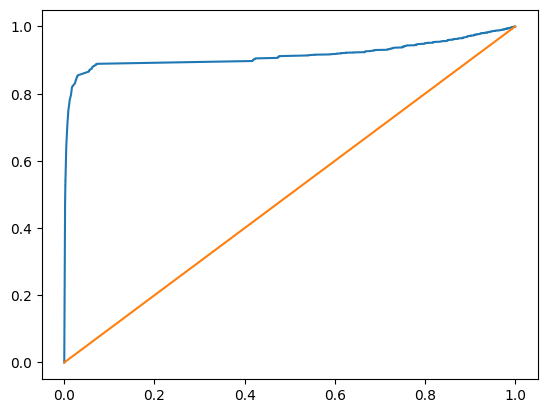

In [173]:
# params = dict(average='weighted')
params = dict()

print(f'prec train: {precision_score(gt_train, preds_train.argmax(axis=1), **params):.3f} valid: {precision_score(gt_valid, preds_valid.argmax(axis=1), **params):.3f}')
print(f'recall train: {recall_score(gt_train, preds_train.argmax(axis=1), **params):.3f} valid: {recall_score(gt_valid, preds_valid.argmax(axis=1), **params):.3f}')
print(f'f1 train: {f1_score(gt_train, preds_train.argmax(axis=1), **params):.3f} valid: {f1_score(gt_valid, preds_valid.argmax(axis=1), **params):.3f}')
print(f'roc auc train: {roc_auc_score(gt_train, preds_train[:, 1], **params):.3f} valid: {roc_auc_score(gt_valid, preds_valid[:, 1], **params):.3f}')

print(f'\nbalanced acc train: {balanced_accuracy_score(gt_train, preds_train.argmax(axis=1)):.3f} valid: {balanced_accuracy_score(gt_valid, preds_valid.argmax(axis=1)):.3f}')

fpr, tpr, tr = roc_curve(valid[target], preds_valid[:, 1])
_ = plt.plot(fpr, tpr)
_ = plt.plot((0, 1), (0, 1))

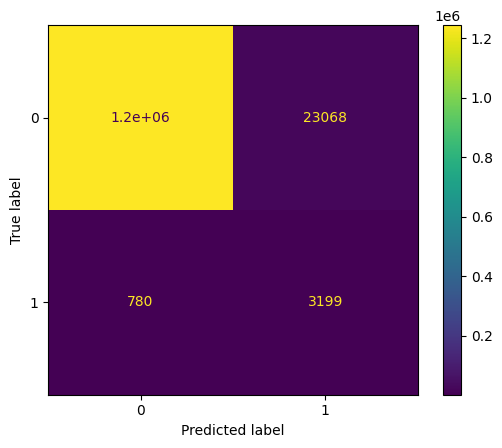

In [47]:
ConfusionMatrixDisplay(confusion_matrix(valid[target], preds_valid.argmax(axis=1))).plot()

# prepare data

In [175]:
test_pred = model.predict_proba(test[features]).argmax(axis=1)
print('friends percentage: ', sum(test_pred) / len(test_pred))

friends percentage:  0.01980020016789188


In [176]:
test_pred = test[['user1', 'user2']].assign(is_friends=test_pred)
res = test_pred.assign(ID=list(range(len(test_pred))))[['ID', 'is_friends']]
print(res)
print(sum(res['is_friends']))
print('friends percentage: ', sum(res['is_friends']) / len(res))
res.to_csv('pred.csv', index=False)

            ID  is_friends
0            0           0
1            1           0
2            2           0
3            3           0
4            4           0
...        ...         ...
706402  706402           0
706403  706403           0
706404  706404           0
706405  706405           0
706406  706406           0

[706407 rows x 2 columns]
13987
friends percentage:  0.01980020016789188
